In [14]:
!pip install kagglehub pandas spacy es_core_news_sm matplotlib wordcloud unidecode -q


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.11.4 requires numpy<1.28.0,>=1.21.6, but you have numpy 2.2.5 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: C:\Users\USUARIO\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [15]:
import kagglehub, pandas as pd, os, unicodedata, re, matplotlib.pyplot as plt, spacy, importlib
try:
    nlp = spacy.load("es_core_news_sm")
except OSError:
    import spacy.cli, importlib.util
    spacy.cli.download("es_core_news_sm")
    nlp = spacy.load("es_core_news_sm")
root = kagglehub.dataset_download("mexwell/amazon-reviews-multi")
load_es = lambda s: pd.read_csv(os.path.join(root, f"{s}.csv"), encoding="latin-1").query('language=="es"').drop(columns="language")
df = pd.concat([load_es(s) for s in ["train", "validation", "test"]], ignore_index=True)
df.to_csv("amazon_reviews_es.csv", index=False)
print(f"Reseñas españolas: {len(df):,}")
df.head()


Reseñas españolas: 210,000


,Unnamed: 0,review_id,product_id,reviewer_id,stars,review_body,review_title,product_category
0,400000,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,electronics
1,400001,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,electronics
2,400002,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,drugstore
3,400003,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,wireless
4,400004,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,shoes


#### Descripción del caso de uso  
Queremos **clasificar el sentimiento** de las reseñas de productos de Amazon.es para que los vendedores identifiquen rápidamente problemas, detecten tendencias y mejoren la experiencia del cliente.


#### Descripción del dataset  
Utilizamos el subset en español del corpus **Amazon Reviews Multi** (200 000 reseñas). Cada fila representa la evaluación de un usuario sobre un producto, con la calificación en estrellas como etiqueta de sentimiento y otros metadatos que permiten filtrar o agrupar los textos. A continuación se detallan las variables disponibles:

| Variable           | Tipo                | Descripción                                                                                  |
|--------------------|---------------------|----------------------------------------------------------------------------------------------|
| `review_id`        | *string*            | Identificador único de la reseña.                                                            |
| `product_id`       | *string*            | Identificador único del producto.                                                            |
| `reviewer_id`      | *string*            | Identificador del usuario que escribe la reseña.                                             |
| `stars`            | *entero (1‑5)*      | Calificación otorgada al producto; será nuestra variable objetivo.                           |
| `review_title`     | *texto corto*       | Título resumido de la reseña.                                                                |
| `review_body`      | *texto*             | Cuerpo completo de la reseña; fuente principal para el análisis de sentimientos.             |
| `language`         | *código ISO 639‑1*  | Idioma del texto (aquí siempre “es” tras el filtrado).                                       |
| `product_category` | *categoría*         | Categoría general del producto (por ejemplo, *electronics*, *toy*, *sports*).                |


### 2. Inspección rápida  
Revisamos tipos, valores nulos, duplicados y estadísticas descriptivas básicas.  


In [16]:
display(df.info())
print("\nDuplicados:", df.duplicated().sum())
print("\nNulos por columna:\n", df.isna().sum())
display(df.describe(include="all").T)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210000 entries, 0 to 209999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Unnamed: 0        210000 non-null  int64 
 1   review_id         210000 non-null  object
 2   product_id        210000 non-null  object
 3   reviewer_id       210000 non-null  object
 4   stars             210000 non-null  int64 
 5   review_body       210000 non-null  object
 6   review_title      210000 non-null  object
 7   product_category  210000 non-null  object
dtypes: int64(2), object(6)
memory usage: 12.8+ MB


None


Duplicados: 0

Nulos por columna:
 Unnamed: 0          0
review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
product_category    0
dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,210000.0,NaN,NaN,NaN,476785.214286,118122.098049,10000.0,442499.75,494999.5,547499.25,599999.0
review_id,210000,210000,es_0491108,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_id,210000,156458,product_es_0261843,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reviewer_id,210000,187140,reviewer_es_0431022,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stars,210000.0,NaN,NaN,NaN,3.0,1.414217,1.0,2.0,3.0,4.0,5.0
review_body,210000,208127,Buena relaciÃ³n calidad precio,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_title,210000,117156,Bien,2040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_category,210000,30,home,28328,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3. Preprocesamiento / normalización de texto  
Minúsculas, eliminación de tildes, URLs, números y puntuación; tokenización + lematización con spaCy y filtrado de *stop‑words*.


In [19]:
from tqdm import tqdm   # barra de progreso

STOP_ES = nlp.Defaults.stop_words
URL_NUM_RE  = re.compile(r"http\S+|www\S+|\d+")
NON_ALPHA_RE = re.compile(r"[^a-zñáéíóúü\s]")

def _pre(text: str) -> str:
    """Minúsculas, quita tildes, URLs, números y signos antes de spaCy."""
    text = unicodedata.normalize("NFD", text.lower()).encode("ascii", "ignore").decode()
    return NON_ALPHA_RE.sub(" ", URL_NUM_RE.sub(" ", text))

cleaned = []
# Procesamos en lotes de 2000 usando 4 procesos; ajusta n_process según tu CPU
for doc in tqdm(nlp.pipe(df.review_body.map(_pre), batch_size=2000, n_process=11),
                total=len(df)):
    toks = [t.lemma_ for t in doc if t.is_alpha and t.lemma_ not in STOP_ES and len(t) > 2]
    cleaned.append(" ".join(toks))

df["clean_body"] = cleaned
df["length"] = df.clean_body.str.split().str.len()
df.to_csv("amazon_reviews_es_clean_spacy.csv", index=False)
df[["review_body", "clean_body"]].head()

100%|██████████| 210000/210000 [02:21<00:00, 1489.34it/s]


,review_body,clean_body
0,Nada bueno se me fue ka pantalla en menos de 8...,pantallar mes recibir respuesta fabricante
1,"Horrible, nos tuvimos que comprar otro porque ...",horrible comprar ing él informatico despua hor...
2,Te obligan a comprar dos unidades y te llega s...,obligar comprar unidad llegar forma reclamar a...
3,"No entro en descalificar al vendedor, solo pue...",entrar descalificar vendedor mes espera seguir...
4,Llega tarde y co la talla equivocada,llegar talla equivocado


In [20]:
display(df.info())
print("\nDuplicados:", df.duplicated().sum())
print("\nNulos por columna:\n", df.isna().sum())
display(df.describe(include="all").T)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210000 entries, 0 to 209999
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Unnamed: 0        210000 non-null  int64 
 1   review_id         210000 non-null  object
 2   product_id        210000 non-null  object
 3   reviewer_id       210000 non-null  object
 4   stars             210000 non-null  int64 
 5   review_body       210000 non-null  object
 6   review_title      210000 non-null  object
 7   product_category  210000 non-null  object
 8   clean_body        210000 non-null  object
 9   length            210000 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 16.0+ MB


None


Duplicados: 0

Nulos por columna:
 Unnamed: 0          0
review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
product_category    0
clean_body          0
length              0
dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,210000.0,NaN,NaN,NaN,476785.214286,118122.098049,10000.0,442499.75,494999.5,547499.25,599999.0
review_id,210000,210000,es_0491108,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_id,210000,156458,product_es_0261843,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reviewer_id,210000,187140,reviewer_es_0431022,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stars,210000.0,NaN,NaN,NaN,3.0,1.414217,1.0,2.0,3.0,4.0,5.0
review_body,210000,208127,Buena relaciÃ³n calidad precio,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_title,210000,117156,Bien,2040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_category,210000,30,home,28328,NaN,NaN,NaN,NaN,NaN,NaN,NaN
clean_body,210000,201314,calidad precio,408,NaN,NaN,NaN,NaN,NaN,NaN,NaN
length,210000.0,NaN,NaN,NaN,10.588348,9.199117,0.0,5.0,8.0,13.0,198.0


### 4. Visualizaciones exploratorias  
Distribución de estrellas, longitud versus calificación, categorías más frecuentes, top‑tokens y nubes de palabras por sentimiento.


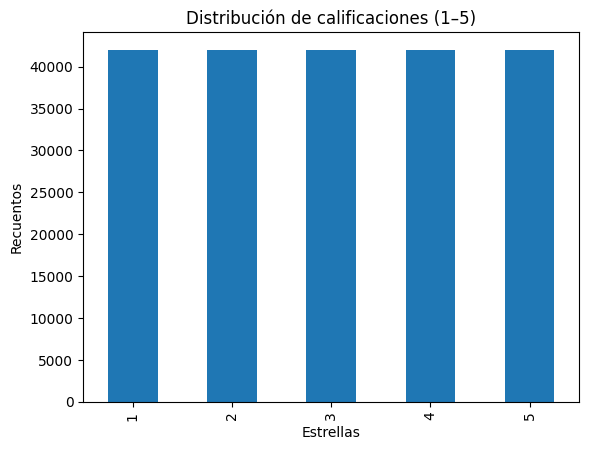

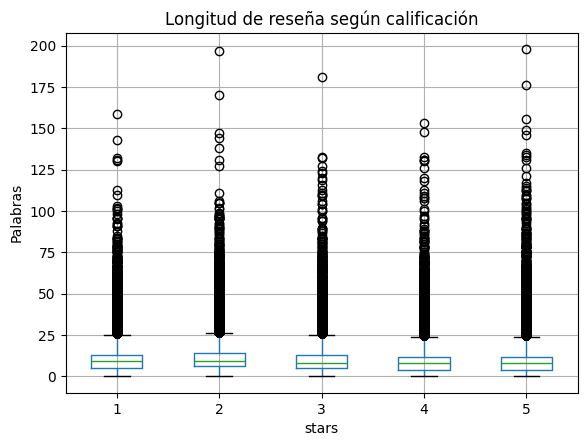

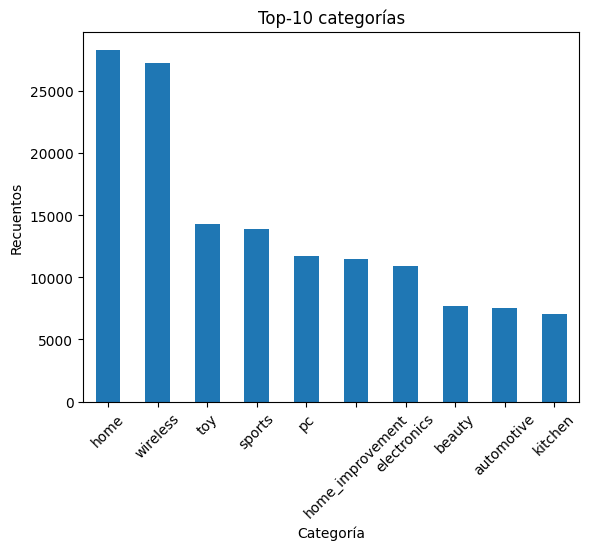

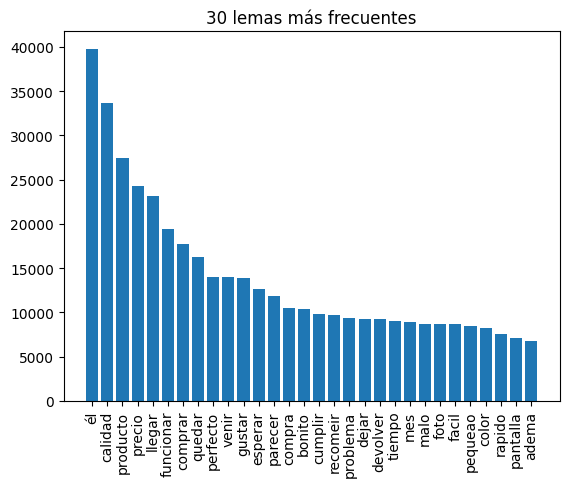

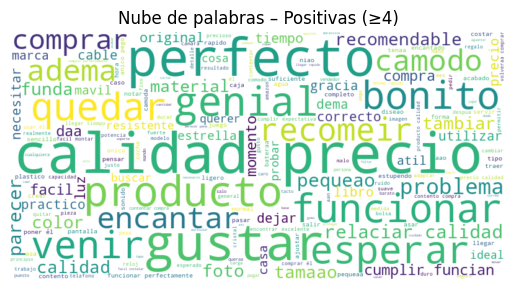

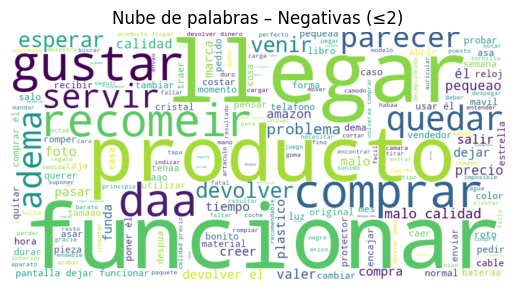

In [21]:
# 4.1 distribución de estrellas
df.stars.value_counts().sort_index().plot.bar()
plt.title("Distribución de calificaciones (1–5)"); plt.xlabel("Estrellas"); plt.ylabel("Recuentos")
plt.show()

# 4.2 longitud por calificación
df.boxplot(column="length", by="stars"); plt.suptitle("")
plt.title("Longitud de reseña según calificación"); plt.ylabel("Palabras")
plt.show()

# 4.3 top‑10 categorías
df.product_category.value_counts().head(10).plot.bar()
plt.title("Top‑10 categorías"); plt.xlabel("Categoría"); plt.ylabel("Recuentos"); plt.xticks(rotation=45)
plt.show()

# 4.4 top‑30 lemas
from collections import Counter
words, freqs = zip(*Counter(" ".join(df.clean_body).split()).most_common(30))
plt.bar(words, freqs); plt.xticks(rotation=90)
plt.title("30 lemas más frecuentes"); plt.show()

# 4.5 nubes de palabras positivas y negativas
from wordcloud import WordCloud
for subset, title in [(df.query("stars>=4"), "Positivas (≥4)"), (df.query("stars<=2"), "Negativas (≤2)")]:
    wc = WordCloud(width=800, height=400, background_color="white").generate(" ".join(subset.clean_body))
    plt.imshow(wc, interpolation="bilinear"); plt.axis("off"); plt.title(f"Nube de palabras – {title}")
    plt.show()


### 5. Hallazgos clave  

## Composición del Dataset
- **Volumen**: Contiene 210,000 reseñas limpias, sin valores nulos ni duplicados.
- **Distribución de calificaciones**: Prácticamente uniforme, con ≈42,000 reseñas por cada valor de 1 a 5 estrellas, previniendo problemas de desbalance en modelos futuros.

## Características del Texto
- **Longitud media**: 10.6 palabras tras lematización y eliminación de stop-words.
- **Rango intercuartílico (RIC)**: 5–13 palabras, con colas que alcanzan casi 200 palabras.
- **Análisis de box-plots**: 
  - Reseñas de 1–2 estrellas tienden a ser ligeramente más extensas.
  - Diferencia mediana entre grupos es marginal.

## Categorías de Producto
- **Diversidad**: Abarca 30 categorías de producto.
- **Distribución**:
  - Las 10 categorías más comunes, lideradas por *home* (13.5%) y *wireless* (12.9%), representan ≈67% de todas las reseñas.

## Análisis Léxico
- **Lemas frecuentes**: Los 30 lemas más comunes están relacionados con atributos de producto y precio, e.g., “calidad”, “producto”, “precio”, “funcionar”, “comprar”.
- **Contraste semántico en nubes de palabras**:
  - **Reseñas positivas**: Predominan adjetivos como “perfecto” y “bonito”, y verbos de satisfacción como “encantar” y “gustar”.
  - **Reseñas negativas**: Énfasis en verbos asociados a fallos o logística (“funcionar”, “devolver”, “llegar”) y sustantivos relacionados con problemas.

## Potencial del Dataset
- **Escenario balanceado**: Ideal para experimentar con modelos multiclase.
- **Variables adicionales**: Permite incorporar longitud del texto y categoría de producto en los análisis.
- **Explicabilidad**: Facilita la exploración mediante lemas dominantes en cada polaridad (positiva/negativa).

In [ ]:
import spacy, re, unicodedata
nlp = spacy.load("es_core_news_sm", disable=["parser", "ner"])

def preprocess(text):
    text = unicodedata.normalize("NFD", text.lower()).encode("ascii", "ignore").decode()
    text = re.sub(r"http\S+|www\S+|\d+|[^a-zñáéíóúü\s]", " ", text)
    return text

cleaned = []
for doc in nlp.pipe(df.review_body.map(preprocess), batch_size=2000, n_process=4):
    tokens = [tok.lemma_ for tok in doc if tok.is_alpha and not tok.is_stop]
    cleaned.append(" ".join(tokens))

df["clean_body"] = cleaned
df["length"] = df.clean_body.str.split().str.len()